# Jin-Hang Zou created this notebook on MCMC spectral fitting using pymultinest
### (Modified by Shao)

### Original version

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pymultinest
from scipy import optimize
from astropy.io import fits
import os

spactum_n2_382 = np.loadtxt('./ZZ_spectrum_n2_382.txt').T
print(spactum_n2_382.T)

[[2.0769590e+00 1.7320510e+00]
 [6.1957260e+00 3.3166250e+00]
 [7.8990510e+00 3.6055510e+00]
 [8.6572080e+00 3.8729830e+00]
 [9.3680420e+00 4.2426410e+00]
 [7.4039560e+00 4.2426410e+00]
 [2.6040129e+01 6.3245550e+00]
 [2.5607198e+01 6.7823300e+00]
 [3.4071693e+01 7.6157730e+00]
 [3.9908490e+01 8.1853530e+00]
 [2.7714436e+01 7.4833150e+00]
 [3.5717535e+01 8.0622580e+00]
 [3.9526188e+01 8.3066240e+00]
 [4.7120375e+01 8.7177980e+00]
 [6.6642549e+01 1.0000000e+01]
 [4.6177327e+01 8.7749640e+00]
 [3.9882693e+01 8.3666000e+00]
 [5.6588703e+01 9.2736180e+00]
 [5.2873658e+01 8.9442720e+00]
 [5.3587012e+01 8.9442720e+00]
 [5.0016534e+01 8.9442720e+00]
 [4.7776801e+01 8.8317610e+00]
 [5.0032596e+01 8.8317610e+00]
 [3.2152350e+01 7.4161980e+00]
 [4.0021307e+01 7.5498340e+00]
 [3.4758693e+01 7.0710680e+00]
 [3.2399301e+01 6.7823300e+00]
 [4.6050478e+01 7.6157730e+00]
 [3.4333260e+01 6.7082040e+00]
 [3.2648777e+01 6.6332500e+00]
 [3.3249786e+01 6.6332500e+00]
 [3.0693118e+01 6.4031240e+00]
 [4.4459

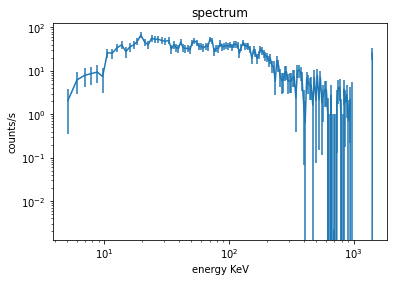

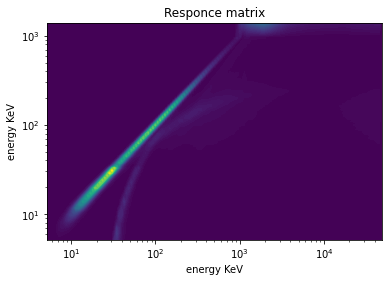

In [2]:
hl = fits.open('./glg_cspec_n2_bn150330828_v00.rsp')
n2_matr = hl[2].data['MATRIX']
n2_matr[-1] = np.zeros(128)
n2_matr = np.vstack(n2_matr)
R_n2 = np.mat(n2_matr)
n2_e_lo = hl[2].data['ENERG_LO']#140
n2_e_hi = hl[2].data['ENERG_HI']
n2_e_min = hl[1].data['E_MIN']#128
n2_e_max = hl[1].data['E_MAX']
hl.close()

n2_e_c = np.sqrt(n2_e_min*n2_e_max)
n2_e_c2 = np.sqrt(n2_e_lo*n2_e_hi) 

plt.title('spectrum')
plt.errorbar(n2_e_c,spactum_n2_382[0],yerr = spactum_n2_382[1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('energy KeV')
plt.ylabel('counts/s')
plt.show()
plt.close()

X,Y = np.meshgrid(n2_e_c2,n2_e_c)
plt.title('Responce matrix')
plt.contourf(X,Y,n2_matr.T,100)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('energy KeV')
plt.ylabel('energy KeV')
plt.show()
plt.close()

## Modified

In [1]:
import os
import socket
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
import rpy2
rpy2_ver = rpy2.__version__
if rpy2_ver[0] == '2':
    import warnings
    from rpy2.rinterface import RRuntimeWarning
    warnings.filterwarnings("ignore", category=RRuntimeWarning)
else:
    from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
    import logging
    rpy2_logger.setLevel(logging.ERROR)
# ---------------------
from rpy2.robjects import r
from rpy2.robjects import numpy2ri
r("library(baseline)")
numpy2ri.activate()
%matplotlib inline

if socket.gethostname() == 'S':
    databasedir = '/db/Data/Fermi_GBM_burst/data/'
    print("Using data from:",databasedir)
elif socket.gethostname() == 'L':
    databasedir = '/home/lang/Work/GBM/data/'
    print("Using data from:",databasedir)
else:
    print("Check your database first!")
cdir = os.getcwd()
resultdir = cdir+'/results/'

Det = ['b0','b1','n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb']
ch1 = 3
ch2 = 124

class GRB:

    def __init__(self, bnname, resultdir):
        self.bnname = bnname
        shortyear = self.bnname[2:4]
        fullyear = '20'+shortyear
        self.datadir = databasedir+'/'+fullyear+'/'+self.bnname+'/'
        self.dataready = True
        for i in range(14):
            ttefile = glob(self.datadir+'glg_tte_'
                            +Det[i]+'_'+self.bnname+'_v*.fit')
            if not len(ttefile) == 1:
                self.dataready = False
            else:
                hdu = fits.open(ttefile[0])
                event = hdu['EVENTS'].data.field(0)
                if len(event) < 10:
                    self.dataready = False
        if self.dataready:
            self.baset1 = None
            self.baset2 = None
            self.binwidth = None
            self.tbins = None
            self.baseresultdir = None
            self.phaIresultdir = None
            self.GTI1 = None
            self.GTI2 = None
            #resultdir = os.getcwd()+'/results/'
            self.resultdir = resultdir+'/'+bnname+'/'
            if not os.path.exists(self.resultdir):
                os.makedirs(self.resultdir)
            self.baseresultdir = self.resultdir+'/base/'
            self.phaIresultdir = self.resultdir+'/phaI/'

            # determine GTI1 and GTI2
            GTI_t1 = np.zeros(14)
            GTI_t2 = np.zeros(14)
            for i in range(14):
                ttefile = glob(self.datadir+'glg_tte_'+Det[i]
                                +'_'+self.bnname+'_v*.fit')
                hdu = fits.open(ttefile[0])
                trigtime = hdu['Primary'].header['TRIGTIME']
                data = hdu['EVENTS'].data
                time = data.field(0)-trigtime
                GTI0_t1 = time[0]
                GTI0_t2 = time[-1]
                timeseq1 = time[:-1]
                timeseq2 = time[1:]
                deltime = timeseq2-timeseq1
                # find a gap larger than 5 second between two events 
                delindex = deltime > 5 
                if len(timeseq1[delindex]) >= 1:
                    GTItmp_t1 = np.array(np.append([GTI0_t1],timeseq2[delindex]))
                    GTItmp_t2 = np.array(np.append(timeseq1[delindex],[GTI0_t2]))
                    for kk in np.arange(len(GTItmp_t1)):
                        if GTItmp_t1[kk] <= 0.0 and GTItmp_t2[kk] >= 0.0:
                            GTI_t1[i] = GTItmp_t1[kk]
                            GTI_t2[i] = GTItmp_t2[kk]
                else:
                    GTI_t1[i] = GTI0_t1
                    GTI_t2[i] = GTI0_t2
            self.GTI1 = np.max(GTI_t1)
            self.GTI2 = np.min(GTI_t2)

    def rawlc(self,viewt1=-50,viewt2=300,binwidth=0.064):
        viewt1 = np.max([self.GTI1,viewt1])
        viewt2 = np.min([self.GTI2,viewt2])
        assert viewt1 < viewt2, self.bnname+': Inappropriate view times for rawlc!'
        if not os.path.exists(self.resultdir+'/'+'raw_lc.png'):
            #print('plotting raw_lc.png ...')
            tbins = np.arange(viewt1,viewt2+binwidth,binwidth)
            fig, axes = plt.subplots(7,2,figsize=(32, 20),
                                sharex=True,sharey=False)
            for i in range(14):
                ttefile = glob(self.datadir+'/'+'glg_tte_'
                            +Det[i]+'_'+self.bnname+'_v*.fit')
                hdu = fits.open(ttefile[0])
                trigtime = hdu['Primary'].header['TRIGTIME']
                data = hdu['EVENTS'].data
                time = data.field(0)-trigtime
                ch = data.field(1)
                #data in firt and last two channels of BGO and NaI are not used
                #ignore 0,1,2,125,126,127, notice 3-124
                goodindex = (ch >= ch1) & (ch <= ch2)  
                time = time[goodindex]
                ebound = hdu['EBOUNDS'].data
                emin = ebound.field(1)
                emin = emin[ch1:ch2+1]
                emax = ebound.field(2)
                emax = emax[ch1:ch2+1]
                histvalue, histbin = np.histogram(time,bins=tbins)
                plotrate = histvalue/binwidth
                plotrate = np.concatenate(([plotrate[0]],plotrate))
                axes[i//2,i%2].plot(histbin,plotrate,drawstyle='steps')
                axes[i//2,i%2].set_xlim([viewt1,viewt2])
                axes[i//2,i%2].tick_params(labelsize=25)
                axes[i//2,i%2].text(0.05,0.85,Det[i],fontsize=25,
                                    transform=axes[i//2,i%2].transAxes)
                axes[i//2,i%2].text(0.7,0.80,(str(round(emin[0],1))
                            +'-'+str(round(emax[-1],1))+' keV'),
                            transform=axes[i//2,i%2].transAxes,fontsize=25)
            fig.text(0.07, 0.5, 'Count rate (count/s)', ha='center',
                        va='center',rotation='vertical',fontsize=30)
            fig.text(0.5, 0.05, 'Time (s)', ha='center',
                                va='center',fontsize=30)
            fig.text(0.5, 0.92, self.bnname, ha='center',
                                va='center',fontsize=30)
            plt.savefig(self.resultdir+'/raw_lc.png')
            plt.close()

Using data from: /home/lang/Work/GBM/data/


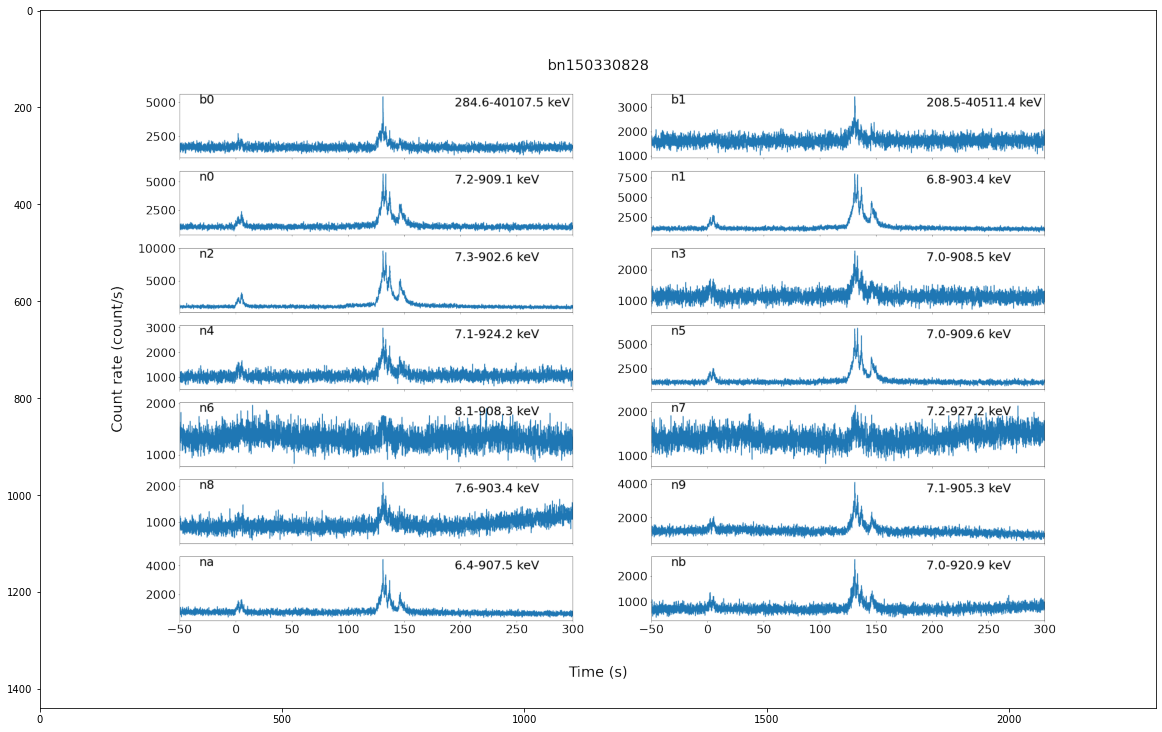

In [64]:
bnname = 'bn150330828'
grb = GRB(bnname,resultdir)
if grb.dataready:
    grb.rawlc(viewt1=-50,viewt2=300,binwidth=0.064)
import matplotlib.image as mpimg
fig, ax = plt.subplots(figsize=(20, 18))
img=mpimg.imread(resultdir+'/'+bnname+'/'+'raw_lc.png')
imgplot = plt.imshow(img)

## New Plot of Spectral Data and Response Matrix

#TODO: effective area

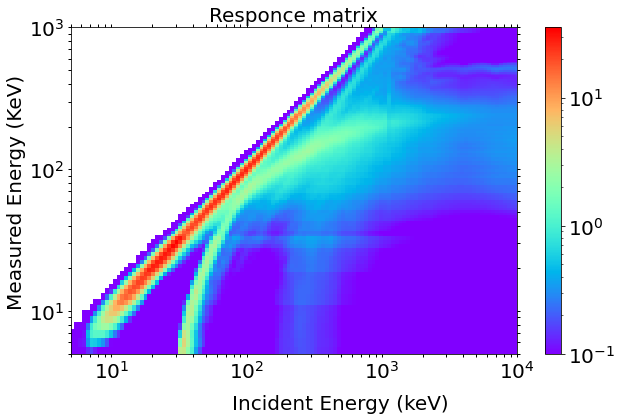

In [37]:
from matplotlib import colors

hdu = fits.open('./glg_cspec_n2_bn150330828_v00.rsp')
ebound = hdu['EBOUNDS'].data
emin = ebound.field(1)
emax = ebound.field(2)
rspdata = hdu['SPECRESP MATRIX'].data
elo = rspdata.field(0)
ehi = rspdata.field(1)
matrix = rspdata.field(5)
filled_matrix = np.zeros((len(emin),len(elo)))
for ii in range(len(emin)):
    for jj in range(len(elo)):
        try:
            filled_matrix[ii][jj] = matrix[jj][ii]
        except:
            pass
x = np.concatenate((elo,[ehi[-1]]))
y = np.concatenate((emin,[emax[-1]]))
X, Y = np.meshgrid(x,y)

fig, ax = plt.subplots(1,1,figsize=(10,6))
plt.title('Responce matrix',fontsize=20)
pcm = ax.pcolormesh(X,Y,filled_matrix,
                    norm=colors.LogNorm(vmin=1E-1, vmax=np.max(filled_matrix)),
                    cmap='rainbow')
cbar = fig.colorbar(pcm, ax=ax,orientation='vertical')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([5,1E4])
ax.set_ylim([5,1000])
ax.tick_params(axis='both',top=True,
                            right=True,length=3,width=1,
                            direction='out',which='both',labelsize=20)
cbar.ax.tick_params(labelsize=20)
fig.text(0.05, 0.5, 'Measured Energy (KeV)',
                ha='center',va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.01, 'Incident Energy (keV)', ha='center',
                                va='center',fontsize=20)
plt.show()
plt.close()

In [3]:

eff_range = np.where((n2_e_c>=8)&(n2_e_c<=800))[0]

def transform(x,R):
    model_mat = np.mat(x)
    return np.array(model_mat*R)[0]


def band(e,cube):
    k = cube[0]
    a = cube[1]
    b = cube[2]
    Ec = cube[3]
    #print(k,a,b,Ec)
    if a<b:
        return [np.nan]
    val = 10**Ec*(a-b)
    a1 = 10**k*(e[e<val]/100)**a*np.exp(-(e[e<val]/10**Ec))
    a2 = 10**k*np.exp(b-a)*(val/100)**(a-b)*(e[e>=val]/100)**b
    A = np.concatenate((a1,a2))
    return A

def prior(cube,ndim,nparams):
    #print('ndim',ndim)
    #print('nparams',nparams)
    cube[0] = (12*cube[0]-5)
    cube[1] = 8*cube[1]-3
    cube[2] = 7*cube[2]-5
    cube[3] = (11.3*cube[3]-1.3)

def log_like(cube,ndim,nparams):
    nn = len(n2_e_lo)
    discr_mod = np.zeros(nn)
    for i in range(nn):
        e = np.linspace(n2_e_lo[i],n2_e_hi[i],5)
        
        try:            
            rate = band(e,cube)
            if True in np.isnan(rate):
                return -np.inf
            sp = rate.mean()*(n2_e_hi[i]-n2_e_lo[i])
            discr_mod[i] = sp
        except:
            print('there are something wrong in your model!')
            print('the model`s parameters are ',cube)
            return -np.inf

    fold_mod = transform(discr_mod,R_n2)  
    return -0.5*(((spactum_n2_382[0][eff_range]-fold_mod[eff_range])/spactum_n2_382[1][eff_range])**2).sum()

parameters = ['log K','a','b','log Ec']
n_params  = len(parameters)
outputdir = './results/'
if os.path.exists(outputdir) == False:
    os.makedirs(outputdir)
pymultinest.run(log_like,prior,n_params,outputfiles_basename = outputdir+'A_n2_',resume = False,verbose =False)
print('Over!!')

Over!!


  analysing data from ./results/A_n2_.txt
The best fit is  [-1.0341658214083758, -0.7603631319464181, -1.8492976547961386, 2.4359288847015135]


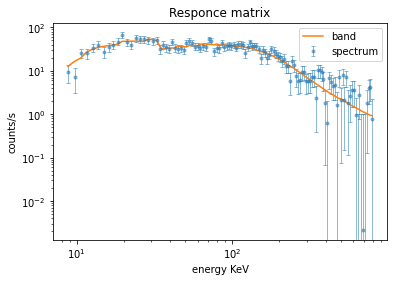

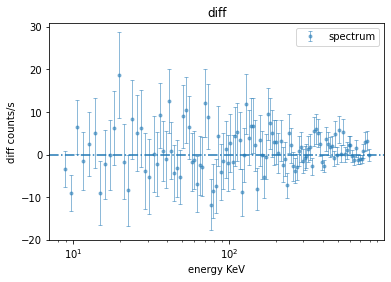

In [4]:
a = pymultinest.Analyzer(outputfiles_basename=outputdir+'A_n2_', n_params = n_params)
best_value = a.get_best_fit()['parameters']
print('The best fit is ',best_value)
nn = len(n2_e_lo)
discr_mod = np.zeros(nn)
for i in range(nn):
    e = np.linspace(n2_e_lo[i],n2_e_hi[i],5)
    rate = band(e,best_value)
    sp = rate.mean()*(n2_e_hi[i]-n2_e_lo[i])
    discr_mod[i] = sp
fold_mod_n2 = transform(discr_mod,R_n2)

plt.title('Responce matrix')
plt.errorbar(n2_e_c[eff_range],spactum_n2_382[0][eff_range],
             yerr = spactum_n2_382[1][eff_range],fmt = '.',elinewidth=1,
             capsize=2,alpha=0.5,label='spectrum')
plt.plot(n2_e_c[eff_range],fold_mod_n2[eff_range],label = 'Band')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Energy (KeV)')
plt.ylabel('counts/s')
plt.show()
plt.close()

plt.title('diff')
plt.errorbar(n2_e_c[eff_range],spactum_n2_382[0][eff_range]-fold_mod_n2[eff_range],
             yerr = spactum_n2_382[1][eff_range],fmt = '.',elinewidth=1,capsize=2,
             alpha=0.5,label='spectrum')
plt.axhline(y=0,linestyle = '-.')
plt.xscale('log')
plt.legend()
plt.xlabel('Energy (KeV)')
plt.ylabel('diff counts/s')
plt.show()
plt.close()


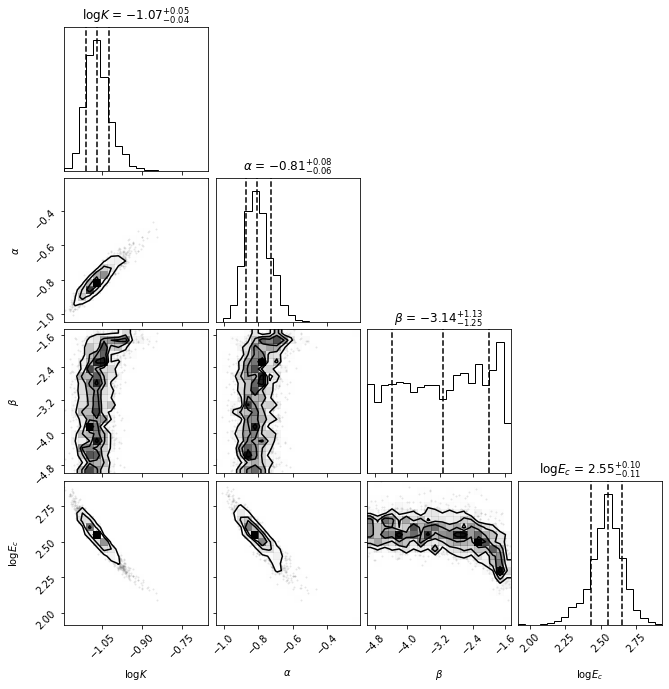

In [15]:
import corner

p = a.get_equal_weighted_posterior()
p1 = p[:,0]
p2 = p[:,1]
p3 = p[:,2]
p4 = p[:,3]
p1234 = np.array([p1,p2,p3,p4]).T
figure = corner.corner(p1234,labels=[r'$\log K$',r'$\alpha$',r'$\beta$',r'$\log E_c$'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})